# Needed imports
Importing all the packages we need for the data we'll be using

In [1]:
# Data manipulation 
import pandas as pd

# Database I/O
import sqlite3

# for some data visualization
import seaborn as sns
import matplotlib.pyplot as plt

# to get neighborhood names
from geopy.geocoders import Nominatim

We're going to first simply see how many rides were taken each year

In [2]:
# Firstly see what tables we got in this database
with sqlite3.connect('data/database/citibike_data.db') as connection:
    all_tables_df = pd.read_sql_query(
        "SELECT name FROM sqlite_master WHERE type='table';",
        connection
    )
all_tables_df.head()

,name
0,citibike_rides_2013
1,citibike_rides_2014
2,citibike_rides_2015
3,citibike_rides_2016
4,citibike_rides_2017


In [3]:
rides_per_year = []
for each_table in all_tables_df['name'].tolist():
    if each_table[-4:].isnumeric():
        with sqlite3.connect('data/database/citibike_data.db') as connection:
            print(f"Retrieving data for {each_table[-4:]}...")
            query = f"""
                Select 
                    strftime('%Y-%m-%d %H:00:00', started_at) AS trip_start_at
                    , strftime('%Y-%m-%d %H:00:00', ended_at) AS trip_end_at
                    , (strftime('%s', ended_at) - strftime('%s', started_at)) / 60 as trip_duration_mins
                    , count(*) as ride_count 
                from {each_table} 
                group by 1,2,3
                """
            rides_per_year.append(
                pd.read_sql_query(
                    query,
                    connection,
                    parse_dates=['trip_start_at','trip_end_at']
                )
            )

rides_by_hour_df = pd.concat(rides_per_year)

# Create a summary table
with sqlite3.connect('data/database/citibike_data.db') as connection:
    rides_by_hour_df.to_sql(
        'ride_counts_by_hour'
        , connection
        , index=False
        , if_exists='replace'
    )

rides_by_hour_df.info()


Retrieving data for 2013...
Retrieving data for 2014...
Retrieving data for 2015...
Retrieving data for 2016...
Retrieving data for 2017...
Retrieving data for 2018...
Retrieving data for 2019...
Retrieving data for 2020...
Retrieving data for 2021...
Retrieving data for 2022...
Retrieving data for 2023...
<class 'pandas.core.frame.DataFrame'>
Index: 9400035 entries, 0 to 1084670
Data columns (total 4 columns):
 #   Column              Dtype         
---  ------              -----         
 0   trip_start_at       datetime64[ns]
 1   trip_end_at         datetime64[ns]
 2   trip_duration_mins  int64         
 3   ride_count          int64         
dtypes: datetime64[ns](2), int64(2)
memory usage: 358.6 MB


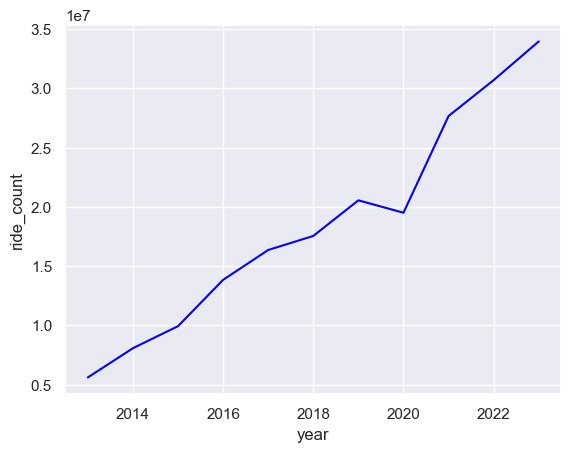

In [4]:
# we'll create a year column and use that to show growth
rides_by_hour_df['year'] = rides_by_hour_df['trip_start_at'].dt.year

sns.set(style='darkgrid')

yearly_rides_df = rides_by_hour_df[['year','ride_count']].groupby('year').sum().reset_index()

sns.lineplot(
    x       = 'year'
    , y     = 'ride_count'
    , data  = yearly_rides_df
    , color = 'blue'
)

plt.show()

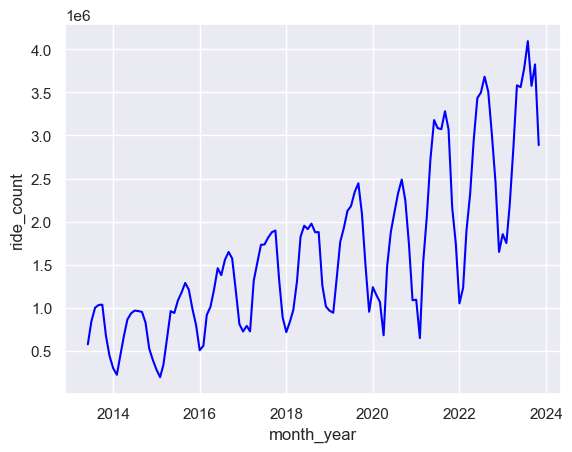

In [5]:
# We'll do the same thing as above but monthly
rides_by_hour_df['month_year'] = pd.to_datetime(rides_by_hour_df['trip_start_at'].dt.strftime('%Y-%m'))

month_year_rides_df = rides_by_hour_df[['month_year','ride_count']].groupby('month_year').sum().reset_index()

sns.lineplot(
    x       = 'month_year'
    , y     = 'ride_count'
    , data  = month_year_rides_df
    , color = 'blue'
)

plt.show()


<Axes: xlabel='month', ylabel='ride_count'>

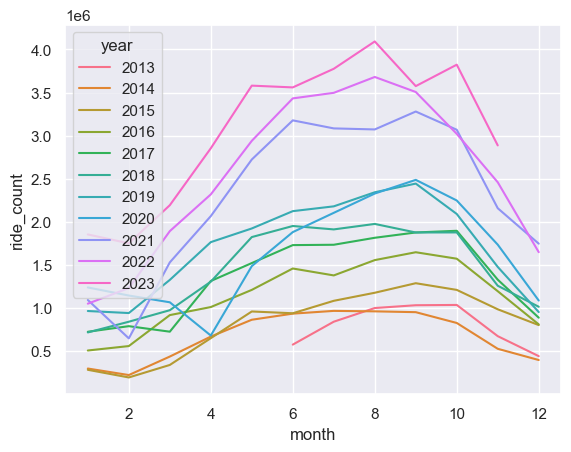

In [6]:
# let's try it but just month, and each year is a different line
rides_by_hour_df['month'] = rides_by_hour_df['trip_start_at'].dt.month

color_palette = sns.color_palette(
    "husl"
    , n_colors = len(rides_by_hour_df['month'].unique())-1
)

monthly_rides_df = rides_by_hour_df[['ride_count','month','year']].groupby(['month','year']).sum().reset_index()

sns.lineplot(
    x='month'
    , y='ride_count'
    , hue='year'
    , data= monthly_rides_df
    , palette= color_palette
)

<Axes: xlabel='hour', ylabel='ride_count'>

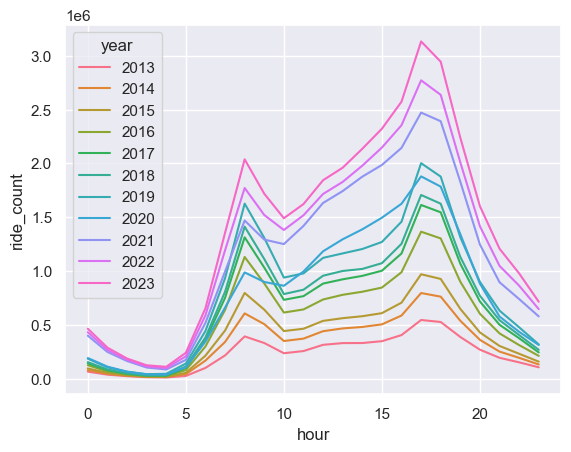

In [7]:
# Let's see what the most popular hour is
# we'll create a month column now
rides_by_hour_df['hour'] = rides_by_hour_df['trip_start_at'].dt.hour

color_palette = sns.color_palette(
    "husl"
    , n_colors = len(rides_by_hour_df['month'].unique())-1
)

hourly_rides_df = rides_by_hour_df[['ride_count','hour','year']].groupby(['hour','year']).sum().reset_index()

sns.lineplot(
    x='hour'
    , y='ride_count'
    , hue='year'
    , data= hourly_rides_df
    , palette= color_palette
)

Let's find what day had the most "heathen hour" rides.

For our purpose, a heathen is someone who is out late at night. Assumingly going to or coming from a bar or similar night venue. No shame, just curiosity.

We define heathen hours as:

1. After a good amount of bars close, which in my experience is 0200 AM
2. Before the morning early birds do anything. Judging from the graph above, maybe we can say that's 0600 AM
3. Is not stolen, which we'll define as a duration is less than 2 hours

In [8]:
# Filter the dataset to the rules above

# After 2AM, before 6AM, and less than 2 hours long
heathens_df = rides_by_hour_df.loc[
        (rides_by_hour_df['hour'] > 2) # After 2 AM
        &
        (rides_by_hour_df['hour'] < 6) # Before 6 AM
        &
        (rides_by_hour_df['trip_duration_mins'] < 120) # Less than 2 hours long
    ]

heathens_columns = list(heathens_df.columns)

heathens_df.head()

,trip_start_at,trip_end_at,trip_duration_mins,ride_count,year,month_year,month,hour
140,2013-06-01 03:00:00,2013-06-01 03:00:00,2,2,2013,2013-06-01,6,3
141,2013-06-01 03:00:00,2013-06-01 03:00:00,3,1,2013,2013-06-01,6,3
142,2013-06-01 03:00:00,2013-06-01 03:00:00,5,2,2013,2013-06-01,6,3
143,2013-06-01 03:00:00,2013-06-01 03:00:00,7,1,2013,2013-06-01,6,3
144,2013-06-01 03:00:00,2013-06-01 03:00:00,9,1,2013,2013-06-01,6,3


Let's see what day and hour had the most heathen activity

In [9]:
heathens_df[['trip_start_at','ride_count']].groupby('trip_start_at').sum().reset_index().sort_values('ride_count', ascending=False).head(5)


,trip_start_at,ride_count
11354,2023-10-29 03:00:00,1663
11351,2023-10-28 03:00:00,1584
8792,2021-06-27 03:00:00,1394
8873,2021-07-24 03:00:00,1383
8939,2021-08-15 03:00:00,1369


That's pretty recently! On October 29, 2023 at 0300AM (according to data through November 2023) we had the most heathens out at 1665!

But perhaps it's a bit too crude. We saw in the earlier graphs that ridership has been pretty quickly growing, so in hindsight it's pretty obvious that the most heathens would have been out fairly recently. Maybe we should do it by a proportion of rides of that month.



In [10]:
# Let's add a summary column that's the total rides for the given month_year
heathens_df = heathens_df[heathens_columns].merge(
    rides_by_hour_df[['month_year', 'ride_count']].groupby('month_year').sum().reset_index().rename(columns={'ride_count':'month_total_ride_count'}),
    on='month_year',
    how='left'
)

heathens_df['heathen_percentage'] = heathens_df['ride_count']/heathens_df['month_total_ride_count']

heathens_df[['trip_start_at', 'heathen_percentage']].groupby('trip_start_at').sum().reset_index().sort_values('heathen_percentage', ascending=False).head()

,trip_start_at,heathen_percentage
10451,2023-01-01 03:00:00,0.000581
7114,2019-12-10 05:00:00,0.000559
9356,2022-01-01 03:00:00,0.000548
7366,2020-03-03 05:00:00,0.000541
7369,2020-03-04 05:00:00,0.000525


Maybe this also seems pretty obvious, but it looks like new years 2023 was the biggest heathen day! Followed pretty closely buy December 10, 2019 at 5AM. What was going on that day???

Googling around for this time, I'm seeing that it was partly cloudy and 57 °F but no major events. I want to know a bit more so I'm going to query the database to see what stations saw a ton of activity that day.

In [11]:
# Connect to the database and get the data that fits the profile
#   (starts after 5AM, )
with sqlite3.connect('data/database/citibike_data.db') as connection:
    query = f"""
        Select 
            start_station_name
            , start_lat
            , start_lng
            , count(*) as heathen_ride_count
        from citibike_rides_2019
        where 
                started_at between '2019-12-10 05:00:00' and '2019-12-10 06:00:00'
            and
                ended_at <= '2019-12-10 08:00:00'
        group by 1,2,3
        order by heathen_ride_count desc
        """
    most_heathenistic_start_df = pd.read_sql_query(
        query,
        connection
    )

most_heathenistic_start_df.info()
    

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 292 entries, 0 to 291
Data columns (total 4 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   start_station_name  292 non-null    object 
 1   start_lat           292 non-null    float64
 2   start_lng           292 non-null    float64
 3   heathen_ride_count  292 non-null    int64  
dtypes: float64(2), int64(1), object(1)
memory usage: 9.3+ KB


In [12]:
most_heathenistic_start_df.head()

,start_station_name,start_lat,start_lng,heathen_ride_count
0,W 41 St & 8 Ave,40.756405,-73.990026,22
1,W 42 St & 8 Ave,40.757570,-73.990985,16
2,W 33 St & 7 Ave,40.750200,-73.990931,8
3,Pershing Square North,40.751873,-73.977706,7
4,E 25 St & 2 Ave,40.739126,-73.979738,6


Looks like most heathens started at W 41 St & 8 Ave, right by times square. That area is the numebr 1 & 2 entries in this list. The top 3 entries are simply in midtown west.

let's see where these heathens terminated their rides

In [13]:
# Connect to the database and get the data that fits the profile
#   (starts after 5AM, )
with sqlite3.connect('data/database/citibike_data.db') as connection:
    query = f"""
        Select 
            end_station_name
            , end_lat
            , end_lng
            , count(*) as heathen_ride_count
        from citibike_rides_2019
        where 
                started_at between '2019-12-10 05:00:00' and '2019-12-10 06:00:00'
            and
                ended_at <= '2019-12-10 08:00:00'
        group by 1,2,3
        order by heathen_ride_count desc
        """
    most_heathenistic_end_df = pd.read_sql_query(
        query,
        connection
    )

most_heathenistic_end_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 263 entries, 0 to 262
Data columns (total 4 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   end_station_name    263 non-null    object 
 1   end_lat             263 non-null    float64
 2   end_lng             263 non-null    float64
 3   heathen_ride_count  263 non-null    int64  
dtypes: float64(2), int64(1), object(1)
memory usage: 8.3+ KB


In [14]:
most_heathenistic_end_df.head()

,end_station_name,end_lat,end_lng,heathen_ride_count
0,W 20 St & 11 Ave,40.746745,-74.007756,15
1,W 21 St & 6 Ave,40.741740,-73.994156,10
2,E 47 St & Park Ave,40.755103,-73.974987,9
3,North Moore St & Greenwich St,40.720195,-74.010301,9
4,University Pl & E 14 St,40.734814,-73.992085,9


Oh interesting, a lot of these people ended their ride just a little south in Chelsey and Flatiron.

Now that I'm this far, I want to see this grouped by neighborhood and that'll prolly be it.

In [15]:
# Let's create a function that'll take a lat and long and return a neighborhood.
def get_nyc_neighborhood(lat, lon):
    # Initialize Nominatim geocoder
    geolocator = Nominatim(user_agent="get_nyc_neighborhood_example")

    # Get location details based on latitude and longitude
    location = geolocator.reverse((lat, lon), language='en', addressdetails=True)

    # Extract neighborhood or address components
    if location and location.raw and 'address' in location.raw:
        address = location.raw['address']
        neighborhood = address.get('neighbourhood', address.get('suburb', None))
        if not neighborhood:
            # For NYC, also consider 'borough' and 'city' components
            neighborhood = address.get('borough', None)
            if not neighborhood:
                neighborhood = address.get('city', None)

    return neighborhood

most_heathenistic_start_df['neighborhood'] = ''

for index, row in most_heathenistic_start_df.iterrows():
    most_heathenistic_start_df.at[index, 'neighborhood'] = get_nyc_neighborhood(
        row['start_lat']
        , row['start_lng']        
    )

most_heathenistic_start_df.head()


,start_station_name,start_lat,start_lng,heathen_ride_count,neighborhood
0,W 41 St & 8 Ave,40.756405,-73.990026,22,Manhattan Community Board 5
1,W 42 St & 8 Ave,40.757570,-73.990985,16,Manhattan Community Board 4
2,W 33 St & 7 Ave,40.750200,-73.990931,8,Chelsea
3,Pershing Square North,40.751873,-73.977706,7,Manhattan Community Board 5
4,E 25 St & 2 Ave,40.739126,-73.979738,6,Manhattan Community Board 6


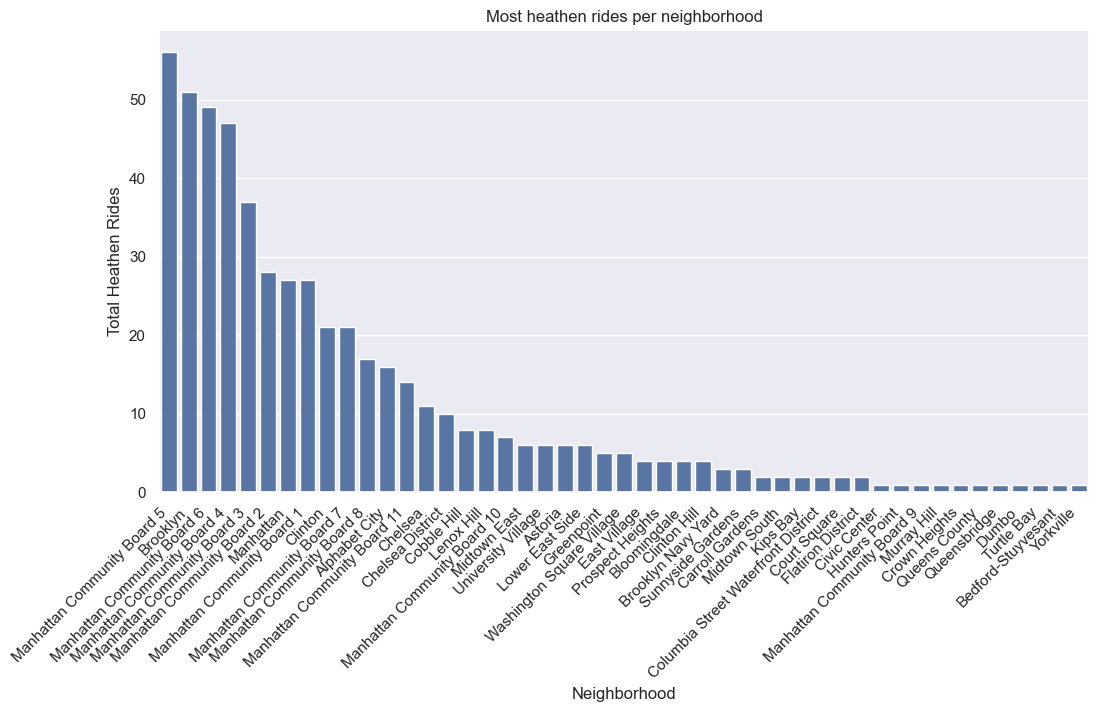

In [16]:
# Aggregating on neighborhood, we get:

# Create a bar graph using Seaborn
plt.figure(figsize=(12, 6))
sns.barplot(
    x = 'neighborhood'
    , y = 'heathen_ride_count'
    , data = most_heathenistic_start_df[['neighborhood','heathen_ride_count']].groupby('neighborhood').sum().reset_index().sort_values('heathen_ride_count', ascending=False)
)

# Rotate x-axis labels for better visibility
plt.xticks(rotation=45, ha='right')

# Add labels and title
plt.xlabel('Neighborhood')
plt.ylabel('Total Heathen Rides')
plt.title('Most heathen rides per neighborhood')

# Show the plot
plt.show()

Ahh yes, Brooklyn. My favorite Neighborhood.

I can't seem to find something I can use that'll return neighborhoods more reliably so I suppose this is it then!